In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [74]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.o = dict()  # orders per data (main, stop, limit, manual-close)
        self.holding = dict()  # holding periods per data

    def notify_order(self, order):
        if order.status == order.Submitted:
            return

        dt, dn = self.datetime.date(), order.data._name
        print('{} {} Order {} Price {} Status {}'.format(
            dt, dn, order.ref, order.executed.price, order.getstatusname())
        )

        whichord = ['main', 'stop', 'limit', 'close']
        if not order.alive():  # not alive - nullify
            dorders = self.o[order.data]
            idx = dorders.index(order)
            dorders[idx] = None
            print('-- No longer alive {} Ref'.format(whichord[idx]))

            if all(x is None for x in dorders):
                dorders[:] = []  # empty list - New orders allowed

                
        # if order.status in [order.Submitted, order.Accepted]:
        #     # Buy/Sell order submitted/accepted to/by broker - Nothing to do
        #     return

        # # Check if an order has been completed
        # # Attention: broker could reject order if not enough cash
        # if order.status in [order.Completed]:
        #     if order.isbuy():
        #         self.log('BUY EXECUTED, %.2f' % order.executed.price)
        #     elif order.issell():
        #         self.log('SELL EXECUTED, %.2f' % order.executed.price)

        #     self.bar_executed = len(self)

        # elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        #     self.log('Order Canceled/Margin/Rejected')

        # # Write down: no pending order
        # self.order = None

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            # if dn == "AAPL":
            print('{} {} Position {}'.format(dt, dn, pos))
            # print(f'Close: {d.close[0]}')

            if not pos and not self.o.get(d, None):  # no market / no orders
                if dn == "AAPL":
                    self.o[d] = [self.buy(data=d)]
                    print('{} {} Buy {}'.format(dt, dn, self.o[d][0].ref))
                    self.holding[d] = 0
                # if dt.weekday() == self.p.enter[i]:
                #     if not self.p.usebracket:
                #         self.o[d] = [self.buy(data=d)]
                #         print('{} {} Buy {}'.format(dt, dn, self.o[d][0].ref))

                #     else:
                #         p = d.close[0] * (1.0 - self.p.pentry)
                #         pstp = p * (1.0 - self.p.plimits)
                #         plmt = p * (1.0 + self.p.plimits)
                #         valid = datetime.timedelta(self.p.valid)

                #         if self.p.rawbracket:
                #             o1 = self.buy(data=d, exectype=bt.Order.Limit,
                #                           price=p, valid=valid, transmit=False)

                #             o2 = self.sell(data=d, exectype=bt.Order.Stop,
                #                            price=pstp, size=o1.size,
                #                            transmit=False, parent=o1)

                #             o3 = self.sell(data=d, exectype=bt.Order.Limit,
                #                            price=plmt, size=o1.size,
                #                            transmit=True, parent=o1)

                #             self.o[d] = [o1, o2, o3]

                #         else:
                #             self.o[d] = self.buy_bracket(
                #                 data=d, price=p, stopprice=pstp,
                #                 limitprice=plmt, oargs=dict(valid=valid))

                #         print('{} {} Main {} Stp {} Lmt {}'.format(
                #             dt, dn, *(x.ref for x in self.o[d])))

                #     self.holding[d] = 0

            elif pos:  # exiting can also happen after a number of days
                self.holding[d] += 1
                if self.holding[d] >= 5:
                    o = self.sell(data=d)
                    self.o[d].append(o)  # manual order to list of orders
                    print('{} {} Manual Close {}'.format(dt, dn, o.ref))
                    # if self.p.usebracket:
                    #     self.cancel(self.o[d][1])  # cancel stop side
                    #     print('{} {} Cancel {}'.format(dt, dn, self.o[d][1]))
                        
        # # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])

        # # Check if an order is pending ... if yes, we cannot send a 2nd one
        # if self.order:
        #     return

        # # Check if we are in the market
        # if not self.position:

        #     # Not yet ... we MIGHT BUY if ...
        #     if self.dataclose[0] < self.dataclose[-1]:
        #             # current close less than previous close

        #             if self.dataclose[-1] < self.dataclose[-2]:
        #                 # previous close less than the previous close

        #                 # BUY, BUY, BUY!!! (with default parameters)
        #                 self.log('BUY CREATE, %.2f' % self.dataclose[0])

        #                 # Keep track of the created order to avoid a 2nd order
        #                 self.order = self.buy(data="AAPL", size=2)

        # else:

        #     # Already in the market ... we might sell
        #     if len(self) >= (self.bar_executed + 5):
        #         # SELL, SELL, SELL!!! (with all possible default parameters)
        #         self.log('SELL CREATE, %.2f' % self.dataclose[0])

        #         # Keep track of the created order to avoid a 2nd order
        #         self.order = self.sell(data="AAPL", size=1)

In [24]:
df = pd.read_csv("./data/nasdaq100_stock_prices.csv", parse_dates=["date"], index_col=0)

In [25]:
df.set_index("date", inplace=True)
tickers = df["ticker"].unique()

In [26]:
df.head()

,open,close,high,low,volume,ticker,company,sector
date,,,,,,,,
2005-01-03,31.493821,30.838949,31.743772,30.768963,5508800,ADBE,Adobe Inc.,Information Technology
2005-01-04,31.098899,30.024111,31.183883,29.674179,7515400,ADBE,Adobe Inc.,Information Technology
2005-01-05,30.084099,29.859142,30.444029,29.859142,3566600,ADBE,Adobe Inc.,Information Technology
2005-01-06,30.109092,29.364239,30.164081,29.239263,6159600,ADBE,Adobe Inc.,Information Technology
2005-01-07,29.499211,29.384233,29.749162,28.844340,8512400,ADBE,Adobe Inc.,Information Technology


In [79]:
def feed_data(start_date, end_date):
    data_feeds = []
    for ticker in tickers:
        df_ticker = df[df["ticker"] == ticker].drop(columns=["ticker"])
        
        # Check if stock has data within the desired period
        if df_ticker.index.min() <= start_date and df_ticker.index.max() >= end_date:
            data = bt.feeds.PandasData(
                dataname=df_ticker,
                fromdate=start_date,
                todate=end_date
            )
            data_feeds.append((ticker, data))
    return data_feeds

In [108]:
start_date = datetime.datetime(2005, 1, 3)
end_date = datetime.datetime(2024, 12, 31)
data_feeds = feed_data(start_date, end_date)

In [109]:
len(data_feeds)

67

In [84]:
STOCK = "AAPL"

In [101]:
import matplotlib.pyplot as pl
from IPython.display import Image

def save_plot(img_path):
    pl.style.use("default") #ggplot is also fine
    pl.rcParams["figure.figsize"] = (25,17)
    
    # Generate the plot
    figs = cerebro.plot(style="candlestick")  # Returns a list of figures
    
    # Extract the first figure correctly
    fig = figs[0][0]  # First figure from the first subplot
    
    # Save the figure
    fig.savefig(img_path)  # Save with high resolution
    
    # Display the saved image
    Image(filename=img_path)

In [110]:
class BuyAndHoldStrategy(bt.Strategy):
    def __init__(self):
        pass  # No indicators needed

    def next(self):
        if self.position.size == 0:  # Buy only at the start
            self.buy()

cerebro = bt.Cerebro()
cerebro.addstrategy(BuyAndHoldStrategy)

for ticker, data in data_feeds:
    if (ticker == STOCK):
        cerebro.adddata(data, name=ticker)
    
cerebro.broker.setcash(100000.0)

cerebro.addsizer(bt.sizers.AllInSizer)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")


print('Buy and Hold Strategy')
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()

img_path = "buyandhold.png"
save_plot(img_path)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")


Buy and Hold Strategy
Starting Portfolio Value: 100000.00
Final Portfolio Value: 24108415.86


<IPython.core.display.Javascript object>

Sharpe Ratio: OrderedDict({'sharperatio': 0.8046097835557823})
Max Drawdown: 60.75877896322654%


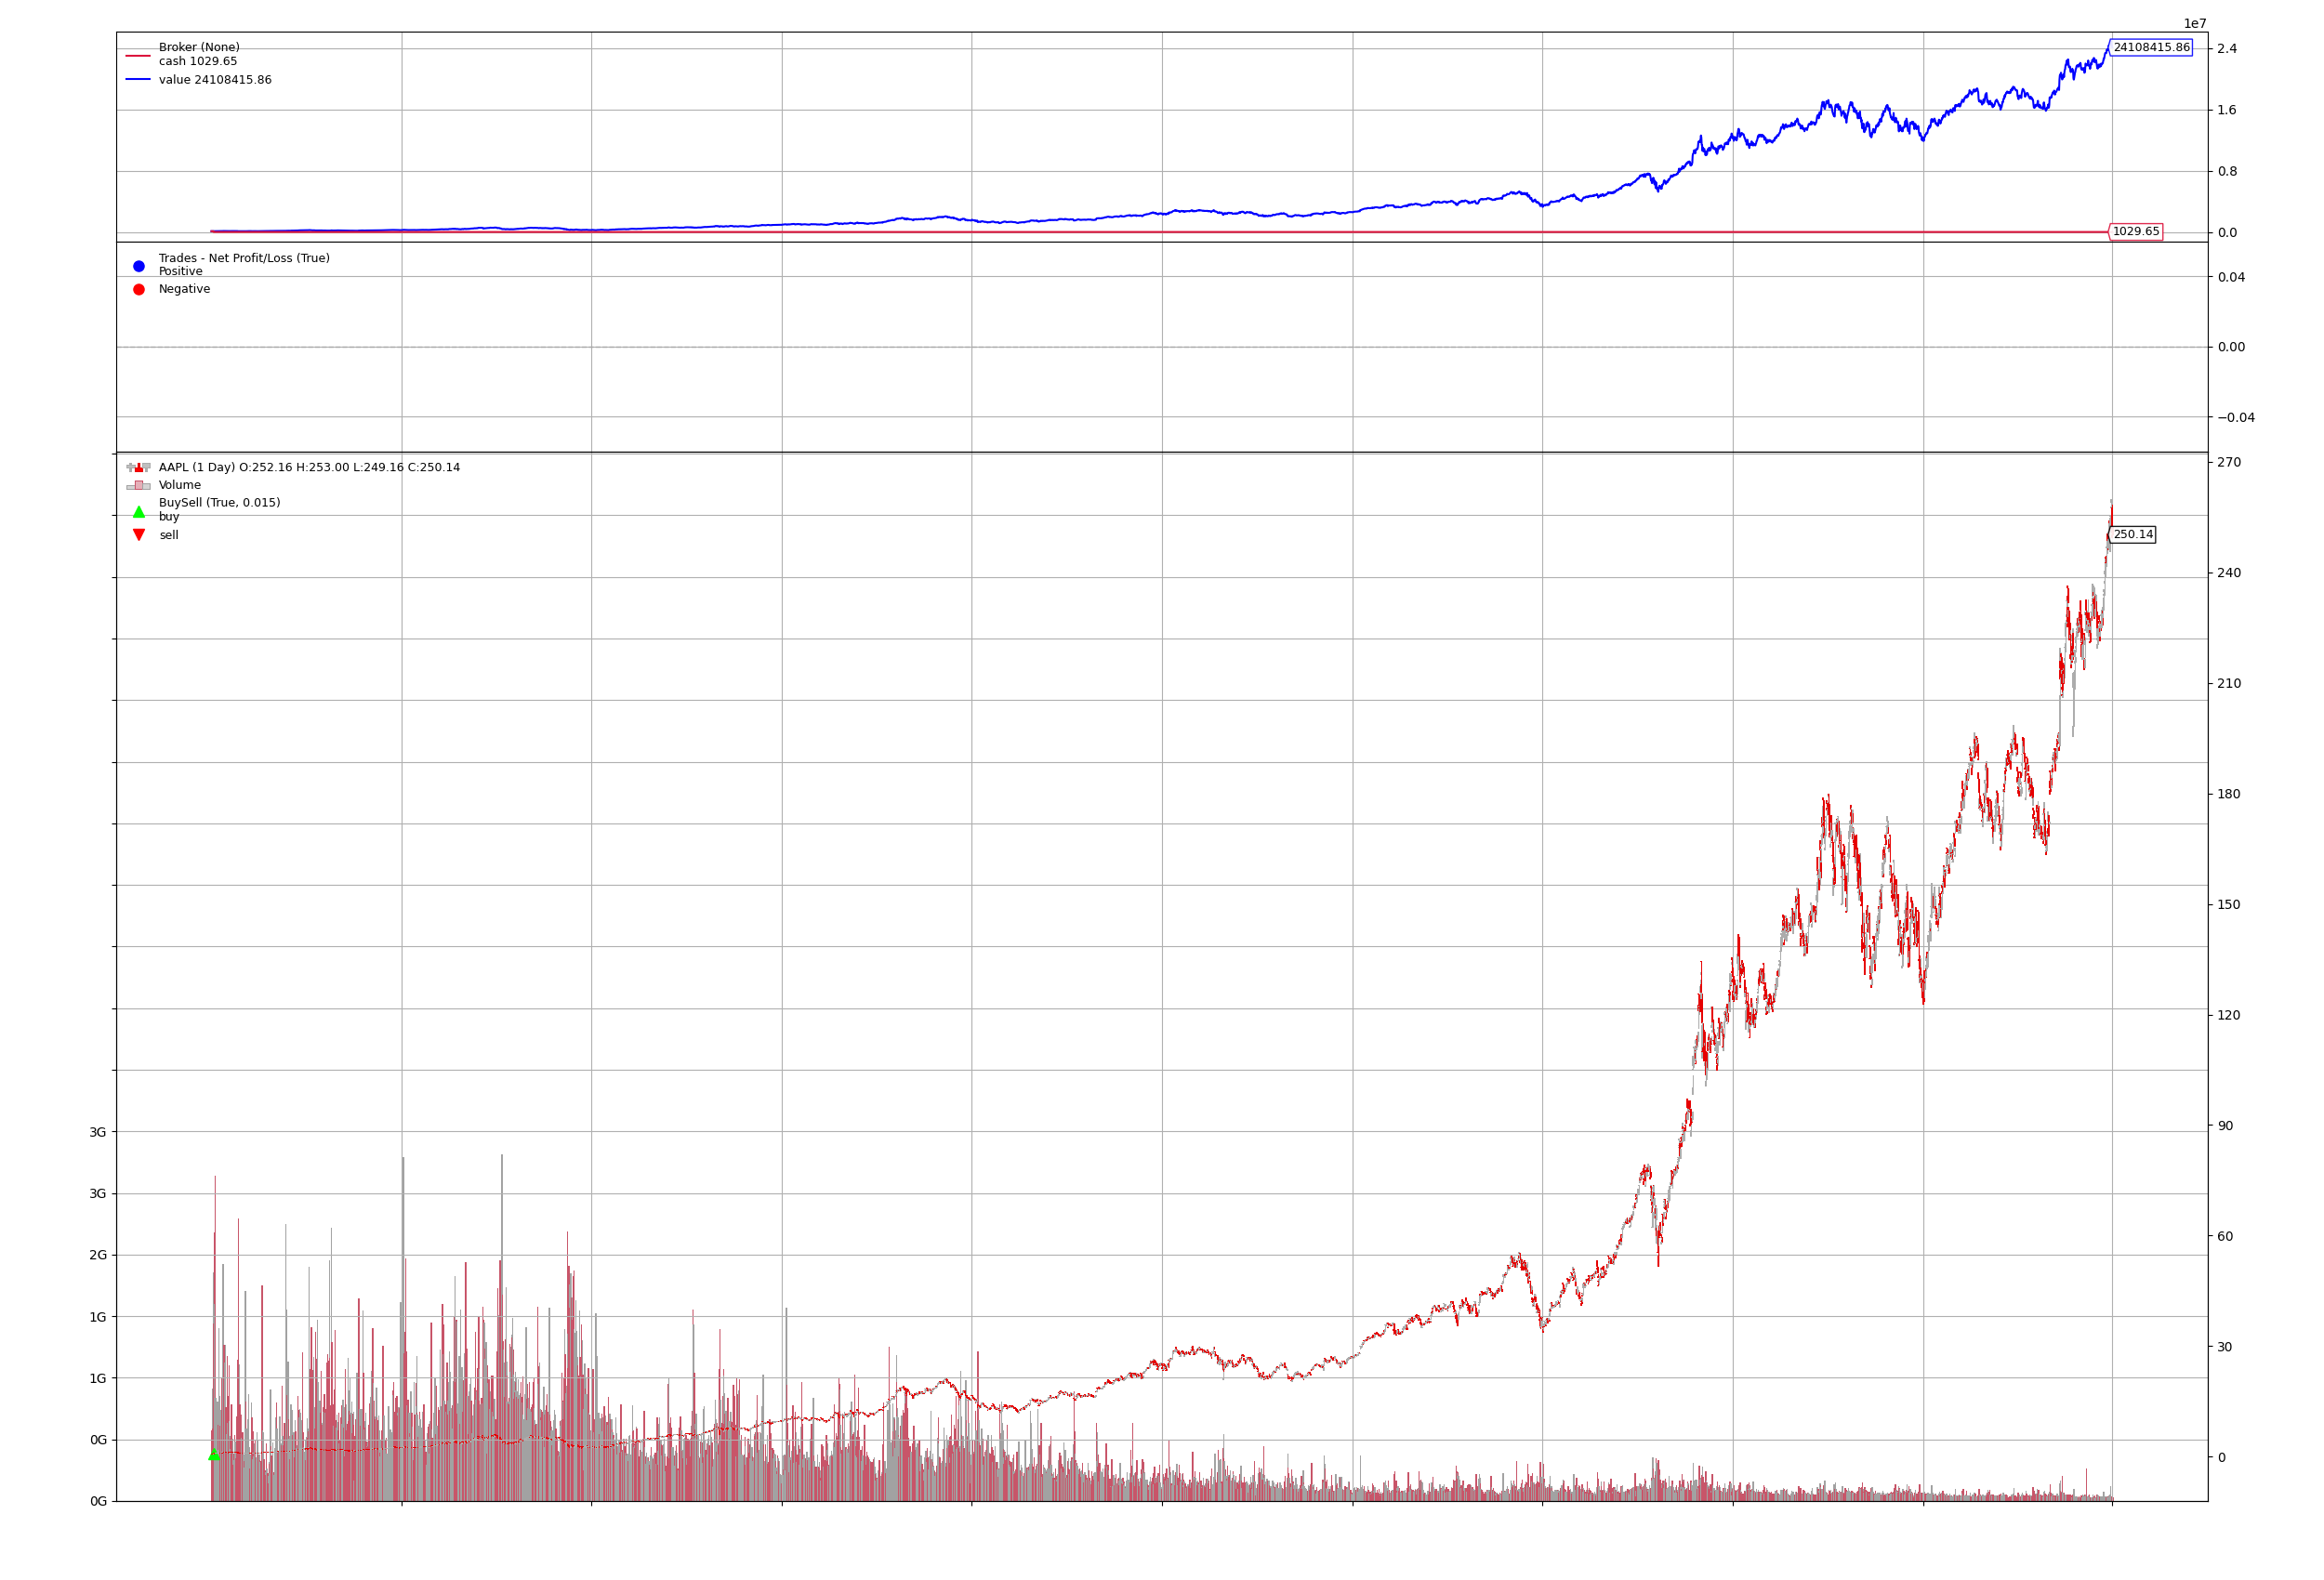

In [111]:
Image(img_path)

In [112]:
class DualMovingAverageStrategy(bt.SignalStrategy):
    params = (
        ('smavg_window', 100),
        ('lmavg_window', 300),
    )

    def __init__(self):

        # Compute long and short moving averages
        smavg = bt.ind.SMA(period=self.p.smavg_window)
        lmavg = bt.ind.SMA(period=self.p.lmavg_window)

        # Go long when short moving average is above long moving average
        self.signal_add(bt.SIGNAL_LONG, bt.ind.CrossOver(smavg, lmavg))

cerebro = bt.Cerebro()
cerebro.addstrategy(MovingAverageCrossover)

for ticker, data in data_feeds:
    if (ticker == STOCK):
        cerebro.adddata(data, name=ticker)
    
cerebro.broker.setcash(100000.0)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")


print('Dual Moving Average Crossover Strategy')
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()

img_path = "dma.png"
save_plot(img_path)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

Dual Moving Average Crossover Strategy
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100152.17


<IPython.core.display.Javascript object>

Sharpe Ratio: OrderedDict({'sharperatio': -54.60730192450425})
Max Drawdown: 0.049178180794625465%


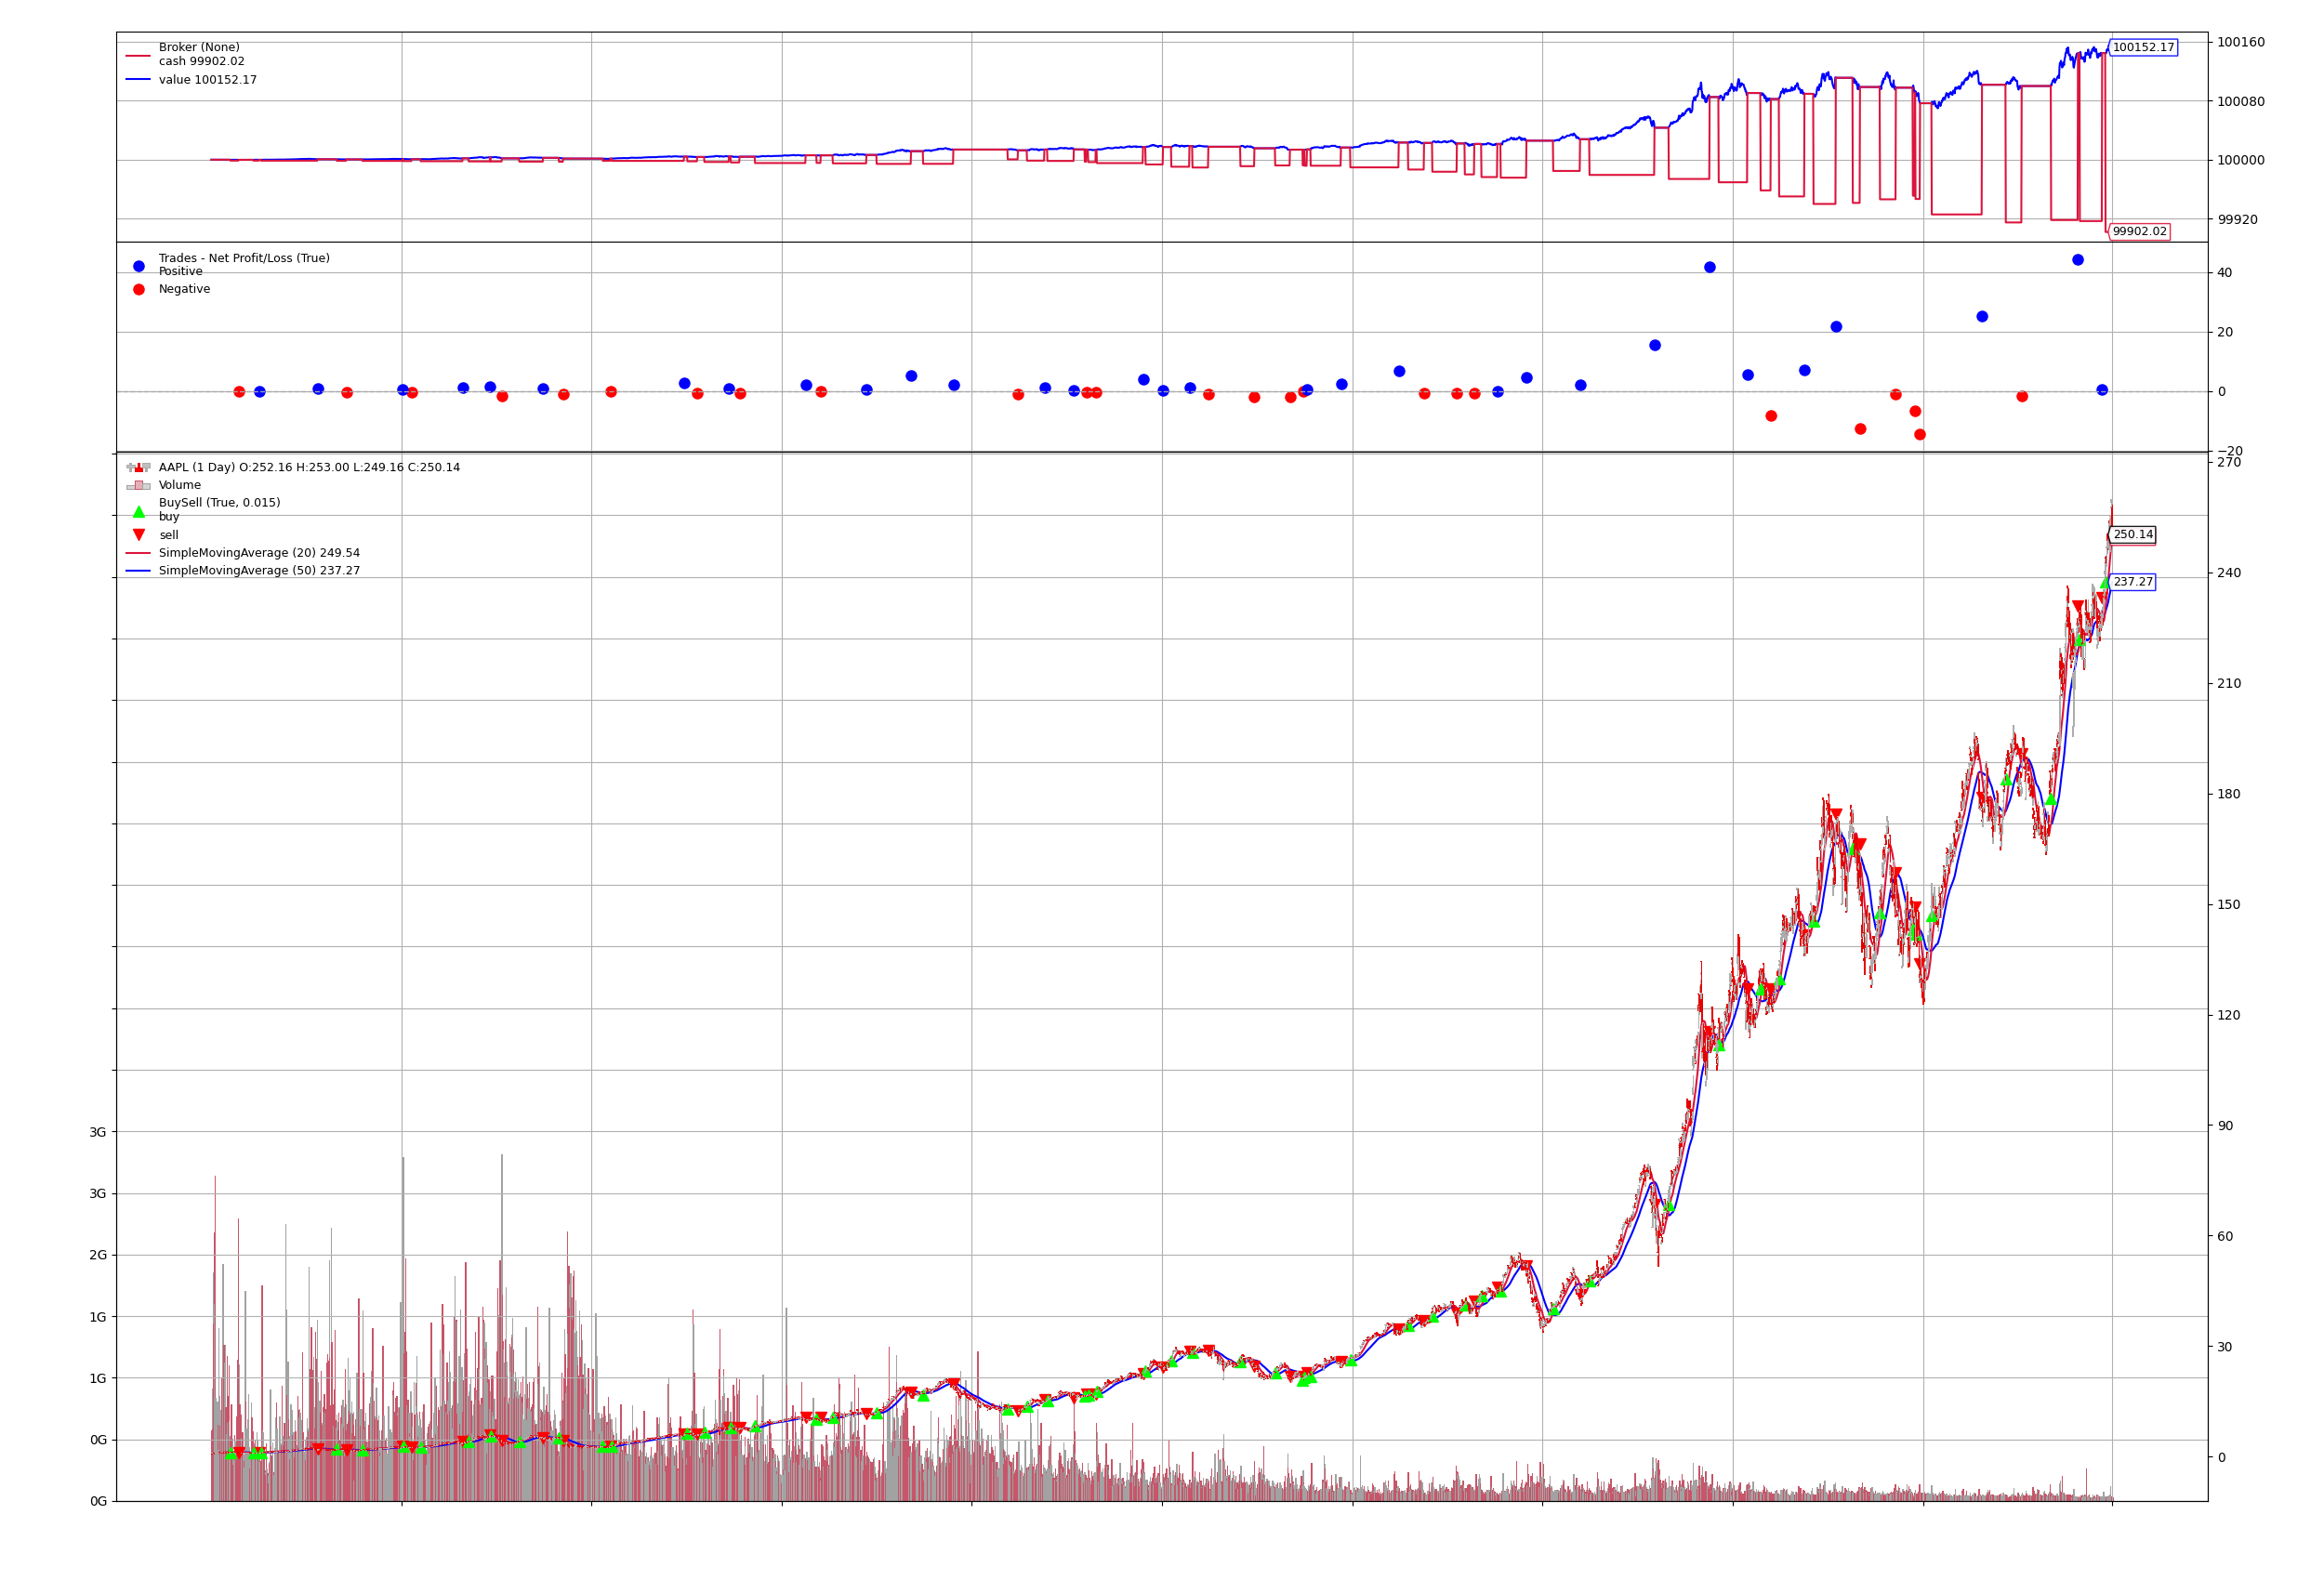

In [113]:
Image(img_path)

In [82]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

for ticker, data in data_feeds:
    if (ticker == STOCK):
        cerebro.adddata(data, name=ticker)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")

print('Our Trading Strategy')
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()

img_path = "ourmodel.png"
save_plot(img_path)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

Starting Portfolio Value: 100000.00
2010-01-04 ADBE Position 0
2010-01-04 AMD Position 0
2010-01-04 GOOGL Position 0
2010-01-04 GOOG Position 0
2010-01-04 AMZN Position 0
2010-01-04 AEP Position 0
2010-01-04 AMGN Position 0
2010-01-04 ADI Position 0
2010-01-04 ANSS Position 0
2010-01-04 AAPL Position 0
2010-01-04 AAPL Buy 823
2010-01-04 AMAT Position 0
2010-01-04 ASML Position 0
2010-01-04 AZN Position 0
2010-01-04 ADSK Position 0
2010-01-04 ADP Position 0
2010-01-04 AXON Position 0
2010-01-04 BKR Position 0
2010-01-04 BIIB Position 0
2010-01-04 BKNG Position 0
2010-01-04 AVGO Position 0
2010-01-04 CDNS Position 0
2010-01-04 CTAS Position 0
2010-01-04 CSCO Position 0
2010-01-04 CCEP Position 0
2010-01-04 CTSH Position 0
2010-01-04 CMCSA Position 0
2010-01-04 CPRT Position 0
2010-01-04 CSGP Position 0
2010-01-04 COST Position 0
2010-01-04 CSX Position 0
2010-01-04 DXCM Position 0
2010-01-04 EA Position 0
2010-01-04 EXC Position 0
2010-01-04 FAST Position 0
2010-01-04 FTNT Position 0
201

In [77]:
for i, d in enumerate(cerebro.datas):
    print(i, d._name, d.datetime.date())

0 ADBE 2010-12-31
1 AMD 2010-12-31


IndexError: array index out of range

In [23]:
import matplotlib.pyplot as pl
pl.style.use("default") #ggplot is also fine
pl.rcParams["figure.figsize"] = (25,17)
from IPython.display import Image

# Set the path to save the image
img_path = "backtrader_plot.png"

# Generate the plot
figs = cerebro.plot(style="candlestick")  # Returns a list of figures

# Extract the first figure correctly
fig = figs[0][0]  # First figure from the first subplot

# Save the figure
# fig.savefig(img_path)  # Save with high resolution

# # Display the saved image
# Image(filename=img_path)


<IPython.core.display.Javascript object>